In [2]:
from dsd import DATA_DIR

coco_annotations_gt_path = DATA_DIR / "real" / "mugs" / "lab-mugs_resized_512x512" / "lab-mugs.json"
coco_annotations_pred_path = DATA_DIR / "real" / "mugs" / "lab-mugs_resized_512x512" / "human-eval-victor.json"

import json
import numpy as np

In [3]:
from airo_dataset_tools.data_parsers.coco import CocoKeypointAnnotation, CocoKeypointCategory, CocoKeypointsDataset

In [4]:
gt_dataset = CocoKeypointsDataset(**json.load(open(coco_annotations_gt_path, "r")))
pred_dataset = CocoKeypointsDataset(**json.load(open(coco_annotations_pred_path, "r")))

In [5]:
# for each image in the prediction dataset, find the corresponding image in the ground truth dataset
# for each annotation category in the prediction dataset, get the corresponding annotation in the ground truth dataset
# compute the distance between the two annotations and store it in a list of distances
from collections import defaultdict

category_channel_distances = defaultdict(list)
gt_image_id_to_image = {image.id: image for image in gt_dataset.images}
gt_image_filename_to_image = {image.file_name: image for image in gt_dataset.images}
pred_image_id_to_image = {image.id: image for image in pred_dataset.images}
category_id_to_category = {category.id: category for category in gt_dataset.categories}


gt_image_id_to_annotations = defaultdict(list)
for annotation in gt_dataset.annotations:
    gt_image_id_to_annotations[annotation.image_id].append(annotation)

for annotation in pred_dataset.annotations:
    pred_image = pred_image_id_to_image[annotation.image_id]
    gt_image = gt_image_filename_to_image[pred_image.file_name]
    gt_annotations = gt_image_id_to_annotations[gt_image.id]
    gt_annotation = None
    for gt_annotation in gt_annotations:
        if gt_annotation.category_id == annotation.category_id:
            break
    
    if gt_annotation is None:
        continue

    gt_keypoints = np.array(gt_annotation.keypoints).reshape(-1, 3)
    pred_keypoints = np.array(annotation.keypoints).reshape(-1, 3)
    channels = category_id_to_category[gt_annotation.category_id].keypoints
    for i, (gt_keypoint, pred_keypoint) in enumerate(zip(gt_keypoints, pred_keypoints)):
        if gt_keypoint[2] == 0 or pred_keypoint[2] == 0:
            continue
        distance = np.linalg.norm(gt_keypoint[:2] - pred_keypoint[:2])
        category_channel_distances[f"{category_id_to_category[gt_annotation.category_id].name}_{channels[i]}"].append(distance)

In [6]:
category_channel_distances.keys()

dict_keys(['mug_bottom', 'mug_handle', 'mug_top'])

In [7]:
print(category_channel_distances["mug_handle"])

[3.6733740469612925, 10.16656393390719, 5.082959855132534, 0.4885047480720201, 7.226330250472179, 13.965654187645105, 0.8606457523924199, 4.260023265455491, 3.661675451362543, 1.187634998174474, 0.7863889340241406, 11.841429812315768, 20.017763722365288, 3.0701100233632643, 12.62651798574909, 20.17484432543548, 10.163612656050121, 12.118634906622118, 6.671163183600145, 17.437189223037063, 15.773087135300356, 9.191275694314088, 13.576973971479147, 4.110122842176118, 6.705294027855893, 7.428125799209988, 5.0809491676697665, 28.80157508038598, 7.4026984869633194, 5.141156376622753, 5.407053911327323, 11.413693452262603, 19.20368785184531, 55.94688195462231, 7.755028246957636, 3.8268118439359955, 7.670285059167535, 10.850650651253854, 13.242912150362631, 16.68019613527105, 16.742493176877165, 18.07370865219541, 2.9220918686600132, 5.837304134234872, 14.307109064300096, 6.187924333373494, 5.640757435348955, 13.46674628689334, 57.011002836684426, 7.151953889983101, 9.168621003788479, 13.8597

In [8]:
mean_distances = {key: np.mean(value) for key, value in category_channel_distances.items()}
median_distances = {key: np.median(value) for key, value in category_channel_distances.items()}
std_distances = {key: np.std(value) for key, value in category_channel_distances.items()}

Text(0.5, 1.0, 'mug_top')

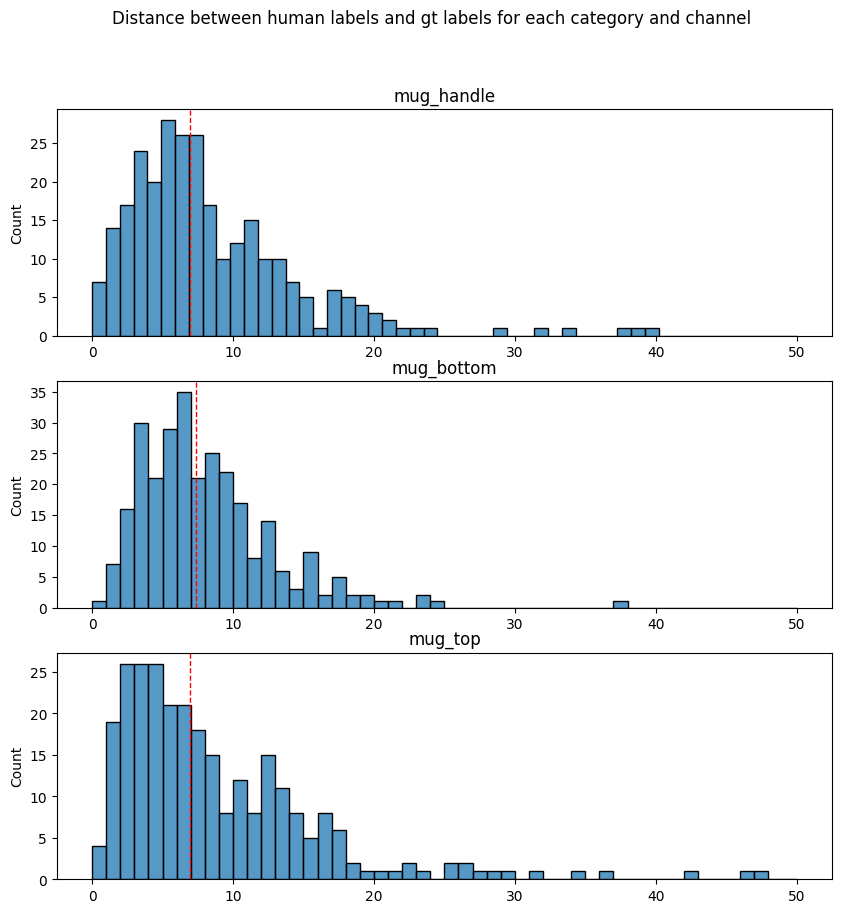

In [28]:
# create distribution plots for each category and channel, single plot 
import matplotlib.pyplot as plt
import seaborn as sns
# make range from 0 to 50
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
# title for the figure
fig.suptitle("Distance between human labels and gt labels for each category and channel")

sns.histplot(category_channel_distances["mug_handle"], ax=ax[0], bins=51, binrange=(0, 50))
# plot the median
ax[0].axvline(median_distances["mug_handle"], color='r', linestyle='dashed', linewidth=1)
ax[0].set_title("mug_handle")
sns.histplot(category_channel_distances["mug_bottom"], ax=ax[1], bins=50, binrange=(0, 50))
ax[1].axvline(median_distances["mug_bottom"], color='r', linestyle='dashed', linewidth=1)
ax[1].set_title("mug_bottom")
sns.histplot(category_channel_distances["mug_top"], ax=ax[2], bins=50, binrange=(0, 50))
ax[2].axvline(median_distances["mug_top"], color='r', linestyle='dashed', linewidth=1)
ax[2].set_title("mug_top")


In [29]:

average_median_distance = np.mean(list(median_distances.values()))
average_median_distance

7.083935551982989